In [4]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
import arviz as az
from statsmodels.tsa import stattools
import statsmodels.api as sm
import pymc3 as pm
import pymc

import sys
sys.path.insert(0, '..')
from utils.plot_lib import set_default

set_default(figsize=(6, 4))

In [11]:
# Read dataset - Infant mortality
cookies = pd.read_csv('data/cookies.dat', sep='\s', engine='python') 
# Checking dataframe
print("The shape of the dataset is: {}".format(cookies.shape))
cookies.head()

The shape of the dataset is: (150, 2)


,"""chips""","""location"""
0,12,1
1,12,1
2,6,1
3,13,1
4,12,1


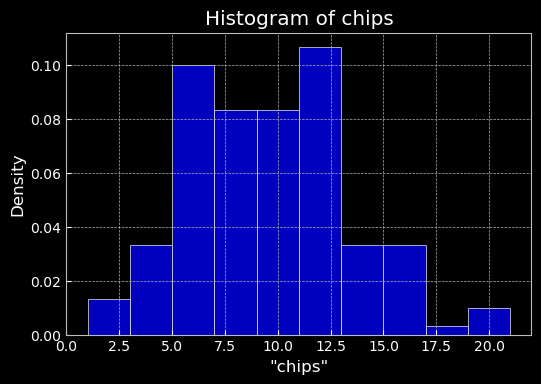

In [16]:
# Plotting the histogram of chips
fig, ax = plt.subplots(1, 1)
sns.histplot(cookies['"chips"'], stat= 'density', bins = 10)
plt.title('Histogram of chips')
plt.show()

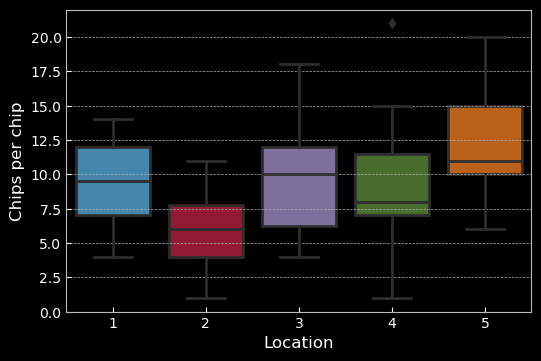

In [23]:
sns.boxplot(x=cookies['"location"'], y = cookies['"chips"'])
plt.xlabel('Location')
plt.ylabel('Chips per chip')
plt.show()

This shows us the distribution of the number of chips by different locations. It looks like maybe location five tends to be more generous on average than the others. 

Let's remind ourselves what this model looks like. We have the $i^{th}$ cookie from the $j^{th}$ location and $y_{ij}$ represents the number of chocolate chips in that cookie. Where $\lambda_j$ is the average or mean number of chips per cookie for location $j$. 

The different location means come from this gamma distribution with these hyper parameters. Before implementing the model, we need to select prior distributions for both $\alpha$ and $\beta$. First, think about what the lambdas represent. 

In location $j$ $\lambda_j$ is the expected number of chocolate chips per cookie. $\alpha$ and $\beta$ control the distribution for these means between locations. The mean of this gamma distribution will  represent the overall mean of number of chips for all cookies. The variance of this gamma distribution controls the variability between locations in the mean number of chips. If this variance is high, the mean number of chips will vary widely from location to location. If it is small, the mean number of chips will be nearly the same from location to location. 

This can be seen below:

$y_{i,j} | \lambda_j \stackrel{ind}{\sim} Poisson(\lambda_j), i = 1,...,30, j = 1,..,5$

$ \lambda_i | \alpha, \beta \stackrel{ind}{\sim} \text{Gamma}(\alpha, \beta), j = 1, ... , 5$

$ \alpha \sim p(\alpha) $

$ \beta \sim p(\beta) $

### Prior predictive checks

To see the effects of different priors on the distribution of $λ’s$, we can simulate. Suppose we try independent exponential priors for $α$ and $β$.

In [62]:
from scipy.stats import expon

np.random.seed(112)
n_sim = 500 # Draw 500 samples
alpha_pri = expon.rvs(size=n_sim, scale = 1 / 0.5) # Exponential prior for alpha with lamb = 1 / scale
beta_pri = expon.rvs(size=n_sim, scale = 1 / 5) # Exponential prior for beta with lamb = 1 / scale
mu_pri = alpha_pri / beta_pri # Mean
sig_pri = np.sqrt(alpha_pri / beta_pri**2) # Stdv

# Describe for mu
print(pd.DataFrame(mu_pri).describe())
print('The meddian is: {}'.format(np.median(mu_pri)))

                 0
count   500.000000
mean     69.729890
std     411.026966
min       0.016805
25%       3.356654
50%       9.851695
75%      32.233714
max    7872.473752
The meddian is: 9.85169500347186


In [63]:
# Describe for sigma
print(pd.DataFrame(sig_pri).describe())
print('The meddian is: {}'.format(np.median(sig_pri)))

                 0
count   500.000000
mean     50.154882
std     350.827310
min       0.283655
25%       3.763907
50%       7.826139
75%      23.253997
max    7132.433397
The meddian is: 7.826138550708875


The last information is the summary of our prior for the mean and stdv of the gamma distribution.

After simulating from the priors for $α$ and $β$, we can use those samples to simulate further down the hierarchy:

In [64]:
from scipy.stats import gamma

# Draw from gamma
lam_pri = gamma.rvs(a = alpha_pri, scale = 1 / beta_pri, size=n_sim)

# Describe lambda
print(pd.DataFrame(lam_pri).describe())
print('The meddian is: {}'.format(np.median(lam_pri)))

                  0
count  5.000000e+02
mean   6.842191e+01
std    4.453380e+02
min    9.528325e-80
25%    1.121539e+00
50%    7.515131e+00
75%    2.926047e+01
max    7.890503e+03
The meddian is: 7.515130932318256


If we want to see what kind of responses this prior model would produce, we can simulate even further down the chain. We now have Monte Carlo samples for $\alpha$ and $\beta$ and $\lambda$. So we could also  enerate samples from the observed number of chocolate chips. We'll call that $y_{prior}$. This will come from the likelihood Poisson. 

In [66]:
from scipy.stats import poisson

# Draw from poisson
y_prior = poisson.rvs(mu = lam_pri, size=n_sim)

# Describe lambda
print(pd.DataFrame(y_prior).describe())
print('The meddian is: {}'.format(np.median(y_prior)))

                 0
count   500.000000
mean     68.964000
std     450.369386
min       0.000000
25%       1.000000
50%       7.000000
75%      30.000000
max    7999.000000
The meddian is: 7.0


If we wanted to create a prior predictive reconstruction of our original data set, say for five locations. We would keep only five of these $\lambda$ draws. We'll reassign $\lambda$ prior to the $\lambda$ prior for the first five values. 

In [71]:
# Draw from gamma
lam_pri = gamma.rvs(a = alpha_pri[:5], scale = 1 / beta_pri[:5], size = 5)
print('The five gammas are: {}'.format(lam_pri))
# Draw from poisson
y_prior = poisson.rvs(mu = np.repeat(lam_pri, 30).shape, size = 155)
print('The five y_i are: {}'.format(y_prior[:5]))

The five gammas are: [21.18155246 62.47153021 59.63757331  0.89710119  3.88506276]
The five y_i are: [157 160 150 177 142]


Because these priors have high variance and are somewhat noninformative, they produce unrealistic predictive distributions. Still, enough data would overwhelm the prior, resulting in useful posterior distributions. Alternatively, we could tweak and simulate from these prior distributions until they adequately represent our prior beliefs. Yet another approach would be to re-parameterize the gamma prior.